# Method 3 - Best Minus Rest

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] == 1].copy()                                                                           
short_ideas = valid_data[valid_data['pos_rank'] != 1].copy()

# Weight the best ideas equally

long_ideas['target'] = 1 / long_ideas.groupby('datadate')[
    'institution_id'].transform('count')

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

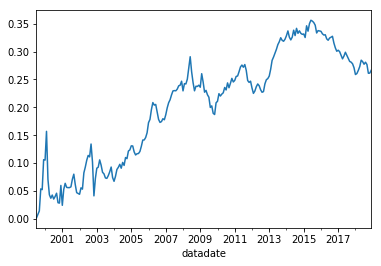

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.106212
2000-12-31   -0.041784
2001-12-31   -0.013533
2002-12-31    0.025378
2003-12-31    0.001855
2004-12-31    0.046144
2005-12-31    0.027361
2006-12-31    0.020149
2007-12-31    0.058729
2008-12-31   -0.005718
2009-12-31   -0.025480
2010-12-31    0.030929
2011-12-31    0.001149
2012-12-31    0.003708
2013-12-31    0.056458
2014-12-31    0.006581
2015-12-31    0.004504
2016-12-31   -0.027183
2017-12-31   -0.022666
2018-12-31   -0.003545
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     21.59
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.97e-15
Time:                        12:57:49   Log-Likelihood:                 741.61
No. Observations:                 234   AIC:                            -1473.
Df Residuals:                     229   BIC:                            -1456.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.569      0.570      -0.001       0.002
mktrf         -0.0518      0.019     -2.702      0.007      -0.090      -0.014
me             0.1804      0.022      8.087      0.000       0.136       0.224
ia            -0.1210      0.034     -3.569      0.000      -0.188      -0.054
roe            0.1180      0.029      4.066      0.000       0.061       0.175
==============================================================================
Omnibus:                       49.880   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              627.995
Skew:                          -0.284   Prob(JB):                    4.29e-137
Kurtosis:                      11.005   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     10.21
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.27e-07
Time:                        12:57:49   Log-Likelihood:                 741.61
No. Observations:                 234   AIC:                            -1473.
Df Residuals:                     229   BIC:                            -1456.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.563      0.573      -0.001       0.002
mktrf         -0.0518      0.026     -1.963      0.050      -0.104   -6.86e-05
me             0.1804      0.037      4.932      0.000       0.109       0.252
ia            -0.1210      0.069     -1.755      0.079      -0.256       0.014
roe            0.1180      0.058      2.023      0.043       0.004       0.232
==============================================================================
Omnibus:                       49.880   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              627.995
Skew:                          -0.284   Prob(JB):                    4.29e-137
Kurtosis:                      11.005   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     9.982
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.83e-07
Time:                        12:57:49   Log-Likelihood:                 741.61
No. Observations:                 234   AIC:                            -1473.
Df Residuals:                     229   BIC:                            -1456.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.529      0.597      -0.001       0.002
mktrf         -0.0518      0.021     -2.412      0.016      -0.094      -0.010
me             0.1804      0.036      5.028      0.000       0.110       0.251
ia            -0.1210      0.066     -1.837      0.066      -0.250       0.008
roe            0.1180      0.058      2.034      0.042       0.004       0.232
==============================================================================
Omnibus:                       49.880   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              627.995
Skew:                          -0.284   Prob(JB):                    4.29e-137
Kurtosis:                      11.005   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     12.36
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.29e-10
Time:                        12:57:49   Log-Likelihood:                 732.23
No. Observations:                 234   AIC:                            -1452.
Df Residuals:                     228   BIC:                            -1432.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.264      0.208      -0.001       0.002
mktrf         -0.0775      0.020     -3.864      0.000      -0.117      -0.038
smb            0.1589      0.026      6.008      0.000       0.107       0.211
hml           -0.0688      0.031     -2.205      0.028      -0.130      -0.007
rmw            0.0321      0.035      0.911      0.363      -0.037       0.102
cma           -0.0101      0.045     -0.225      0.822      -0.098       0.078
==============================================================================
Omnibus:                       53.496   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              638.195
Skew:                          -0.417   Prob(JB):                    2.62e-139
Kurtosis:                      11.047   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     6.989
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.27e-06
Time:                        12:57:49   Log-Likelihood:                 732.23
No. Observations:                 234   AIC:                            -1452.
Df Residuals:                     228   BIC:                            -1432.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.221      0.222      -0.001       0.002
mktrf         -0.0775      0.025     -3.158      0.002      -0.126      -0.029
smb            0.1589      0.043      3.704      0.000       0.075       0.243
hml           -0.0688      0.040     -1.703      0.088      -0.148       0.010
rmw            0.0321      0.074      0.432      0.666      -0.114       0.178
cma           -0.0101      0.112     -0.090      0.928      -0.230       0.210
==============================================================================
Omnibus:                       53.496   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              638.195
Skew:                          -0.417   Prob(JB):                    2.62e-139
Kurtosis:                      11.047   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     8.101
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.70e-07
Time:                        12:57:49   Log-Likelihood:                 732.23
No. Observations:                 234   AIC:                            -1452.
Df Residuals:                     228   BIC:                            -1432.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.170      0.242      -0.001       0.003
mktrf         -0.0775      0.023     -3.354      0.001      -0.123      -0.032
smb            0.1589      0.036      4.379      0.000       0.088       0.230
hml           -0.0688      0.040     -1.723      0.085      -0.147       0.009
rmw            0.0321      0.082      0.391      0.696      -0.129       0.193
cma           -0.0101      0.121     -0.083      0.934      -0.247       0.227
==============================================================================
Omnibus:                       53.496   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              638.195
Skew:                          -0.417   Prob(JB):                    2.62e-139
Kurtosis:                      11.047   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     55.37
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-32
Time:                        12:57:49   Log-Likelihood:                 783.33
No. Observations:                 234   AIC:                            -1557.
Df Residuals:                     229   BIC:                            -1539.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.439      0.661      -0.001       0.001
mktrf         -0.0136      0.015     -0.924      0.357      -0.043       0.015
smb            0.0890      0.018      4.826      0.000       0.053       0.125
hml           -0.0021      0.018     -0.112      0.911      -0.038       0.034
umd            0.1372      0.012     11.413      0.000       0.113       0.161
==============================================================================
Omnibus:                       59.751   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              558.091
Skew:                          -0.658   Prob(JB):                    6.49e-122
Kurtosis:                      10.450   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     17.80
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.71e-13
Time:                        12:57:49   Log-Likelihood:                 783.33
No. Observations:                 234   AIC:                            -1557.
Df Residuals:                     229   BIC:                            -1539.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.415      0.678      -0.001       0.001
mktrf         -0.0136      0.021     -0.644      0.520      -0.055       0.028
smb            0.0890      0.027      3.260      0.001       0.035       0.143
hml           -0.0021      0.021     -0.097      0.923      -0.044       0.040
umd            0.1372      0.026      5.354      0.000       0.087       0.187
==============================================================================
Omnibus:                       59.751   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              558.091
Skew:                          -0.658   Prob(JB):                    6.49e-122
Kurtosis:                      10.450   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     19.79
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.27e-14
Time:                        12:57:49   Log-Likelihood:                 783.33
No. Observations:                 234   AIC:                            -1557.
Df Residuals:                     229   BIC:                            -1539.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.403      0.687      -0.001       0.001
mktrf         -0.0136      0.019     -0.728      0.467      -0.050       0.023
smb            0.0890      0.022      4.099      0.000       0.046       0.132
hml           -0.0021      0.019     -0.109      0.913      -0.039       0.035
umd            0.1372      0.027      5.148      0.000       0.085       0.189
==============================================================================
Omnibus:                       59.751   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              558.091
Skew:                          -0.658   Prob(JB):                    6.49e-122
Kurtosis:                      10.450   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     14.02
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.40e-09
Time:                        12:57:49   Log-Likelihood:                 353.60
No. Observations:                 120   AIC:                            -697.2
Df Residuals:                     115   BIC:                            -683.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.119      0.905      -0.003       0.002
mktrf         -0.0273      0.033     -0.817      0.416      -0.094       0.039
me             0.2085      0.033      6.309      0.000       0.143       0.274
ia            -0.1537      0.052     -2.971      0.004      -0.256      -0.051
roe            0.1869      0.046      4.081      0.000       0.096       0.278
==============================================================================
Omnibus:                       23.989   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.754
Skew:                          -0.277   Prob(JB):                     4.99e-33
Kurtosis:                       8.426   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     18.97
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.30e-12
Time:                        12:57:49   Log-Likelihood:                 353.60
No. Observations:                 120   AIC:                            -697.2
Df Residuals:                     115   BIC:                            -683.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.126      0.900      -0.002       0.002
mktrf         -0.0273      0.043     -0.639      0.523      -0.111       0.057
me             0.2085      0.043      4.869      0.000       0.125       0.292
ia            -0.1537      0.087     -1.770      0.077      -0.324       0.017
roe            0.1869      0.074      2.538      0.011       0.043       0.331
==============================================================================
Omnibus:                       23.989   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.754
Skew:                          -0.277   Prob(JB):                     4.99e-33
Kurtosis:                       8.426   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     23.19
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.53e-14
Time:                        12:57:49   Log-Likelihood:                 353.60
No. Observations:                 120   AIC:                            -697.2
Df Residuals:                     115   BIC:                            -683.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.127      0.899      -0.002       0.002
mktrf         -0.0273      0.031     -0.886      0.376      -0.088       0.033
me             0.2085      0.042      4.941      0.000       0.126       0.291
ia            -0.1537      0.085     -1.810      0.070      -0.320       0.013
roe            0.1869      0.066      2.833      0.005       0.058       0.316
==============================================================================
Omnibus:                       23.989   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.754
Skew:                          -0.277   Prob(JB):                     4.99e-33
Kurtosis:                       8.426   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     6.184
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.15e-05
Time:                        12:57:49   Log-Likelihood:                 344.17
No. Observations:                 120   AIC:                            -676.3
Df Residuals:                     114   BIC:                            -659.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.490      0.625      -0.002       0.003
mktrf         -0.0908      0.038     -2.368      0.020      -0.167      -0.015
smb            0.1718      0.043      3.957      0.000       0.086       0.258
hml           -0.0770      0.053     -1.448      0.150      -0.182       0.028
rmw            0.0498      0.063      0.794      0.429      -0.074       0.174
cma           -0.0217      0.069     -0.316      0.753      -0.158       0.114
==============================================================================
Omnibus:                       20.291   Durbin-Watson:                   2.262
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.125
Skew:                          -0.239   Prob(JB):                     2.99e-22
Kurtosis:                       7.427   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     5.250
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000224
Time:                        12:57:49   Log-Likelihood:                 344.17
No. Observations:                 120   AIC:                            -676.3
Df Residuals:                     114   BIC:                            -659.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.479      0.632      -0.002       0.003
mktrf         -0.0908      0.044     -2.061      0.039      -0.177      -0.004
smb            0.1718      0.059      2.898      0.004       0.056       0.288
hml           -0.0770      0.051     -1.517      0.129      -0.177       0.023
rmw            0.0498      0.099      0.504      0.614      -0.144       0.243
cma           -0.0217      0.139     -0.156      0.876      -0.295       0.251
==============================================================================
Omnibus:                       20.291   Durbin-Watson:                   2.262
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.125
Skew:                          -0.239   Prob(JB):                     2.99e-22
Kurtosis:                       7.427   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     6.678
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.72e-05
Time:                        12:57:49   Log-Likelihood:                 344.17
No. Observations:                 120   AIC:                            -676.3
Df Residuals:                     114   BIC:                            -659.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.473      0.636      -0.002       0.003
mktrf         -0.0908      0.042     -2.177      0.029      -0.172      -0.009
smb            0.1718      0.050      3.453      0.001       0.074       0.269
hml           -0.0770      0.048     -1.617      0.106      -0.170       0.016
rmw            0.0498      0.110      0.454      0.649      -0.165       0.265
cma           -0.0217      0.147     -0.147      0.883      -0.310       0.267
==============================================================================
Omnibus:                       20.291   Durbin-Watson:                   2.262
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.125
Skew:                          -0.239   Prob(JB):                     2.99e-22
Kurtosis:                       7.427   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     33.48
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.66e-18
Time:                        12:57:49   Log-Likelihood:                 376.11
No. Observations:                 120   AIC:                            -742.2
Df Residuals:                     115   BIC:                            -728.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.480      0.632      -0.002       0.002
mktrf          0.0066      0.024      0.268      0.789      -0.042       0.055
smb            0.0667      0.028      2.396      0.018       0.012       0.122
hml           -0.0078      0.028     -0.280      0.780      -0.063       0.047
umd            0.1577      0.017      9.177      0.000       0.124       0.192
==============================================================================
Omnibus:                       38.028   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.088
Skew:                          -0.920   Prob(JB):                     2.37e-41
Kurtosis:                       8.833   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     16.19
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.52e-10
Time:                        12:57:49   Log-Likelihood:                 376.11
No. Observations:                 120   AIC:                            -742.2
Df Residuals:                     115   BIC:                            -728.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.461      0.645      -0.002       0.003
mktrf          0.0066      0.032      0.204      0.839      -0.057       0.070
smb            0.0667      0.037      1.792      0.073      -0.006       0.140
hml           -0.0078      0.024     -0.330      0.741      -0.054       0.038
umd            0.1577      0.031      5.083      0.000       0.097       0.218
==============================================================================
Omnibus:                       38.028   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.088
Skew:                          -0.920   Prob(JB):                     2.37e-41
Kurtosis:                       8.833   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     19.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.17e-12
Time:                        12:57:49   Log-Likelihood:                 376.11
No. Observations:                 120   AIC:                            -742.2
Df Residuals:                     115   BIC:                            -728.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.506      0.613      -0.001       0.002
mktrf          0.0066      0.025      0.260      0.795      -0.043       0.056
smb            0.0667      0.027      2.458      0.014       0.013       0.120
hml           -0.0078      0.020     -0.386      0.700      -0.047       0.032
umd            0.1577      0.029      5.481      0.000       0.101       0.214
==============================================================================
Omnibus:                       38.028   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.088
Skew:                          -0.920   Prob(JB):                     2.37e-41
Kurtosis:                       8.833   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     7.478
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.32e-05
Time:                        12:57:49   Log-Likelihood:                 431.51
No. Observations:                 114   AIC:                            -853.0
Df Residuals:                     109   BIC:                            -839.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.768      0.080      -0.000       0.002
mktrf         -0.0602      0.017     -3.647      0.000      -0.093      -0.028
me             0.1058      0.026      4.148      0.000       0.055       0.156
ia            -0.0859      0.035     -2.428      0.017      -0.156      -0.016
roe           -0.0414      0.031     -1.333      0.185      -0.103       0.020
==============================================================================
Omnibus:                        0.527   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.431
Skew:                           0.150   Prob(JB):                        0.806
Kurtosis:                       2.970   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     15.00
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.48e-10
Time:                        12:57:49   Log-Likelihood:                 431.51
No. Observations:                 114   AIC:                            -853.0
Df Residuals:                     109   BIC:                            -839.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.432      0.152      -0.000       0.002
mktrf         -0.0602      0.014     -4.375      0.000      -0.087      -0.033
me             0.1058      0.026      4.002      0.000       0.054       0.158
ia            -0.0859      0.043     -2.007      0.045      -0.170      -0.002
roe           -0.0414      0.029     -1.407      0.159      -0.099       0.016
==============================================================================
Omnibus:                        0.527   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.431
Skew:                           0.150   Prob(JB):                        0.806
Kurtosis:                       2.970   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     18.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.71e-11
Time:                        12:57:49   Log-Likelihood:                 431.51
No. Observations:                 114   AIC:                            -853.0
Df Residuals:                     109   BIC:                            -839.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.245      0.213      -0.001       0.003
mktrf         -0.0602      0.013     -4.676      0.000      -0.086      -0.035
me             0.1058      0.025      4.157      0.000       0.056       0.156
ia            -0.0859      0.047     -1.820      0.069      -0.178       0.007
roe           -0.0414      0.027     -1.529      0.126      -0.095       0.012
==============================================================================
Omnibus:                        0.527   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.431
Skew:                           0.150   Prob(JB):                        0.806
Kurtosis:                       2.970   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     8.555
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.48e-07
Time:                        12:57:49   Log-Likelihood:                 436.70
No. Observations:                 114   AIC:                            -861.4
Df Residuals:                     108   BIC:                            -845.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.677      0.096      -0.000       0.002
mktrf         -0.0527      0.015     -3.486      0.001      -0.083      -0.023
smb            0.1183      0.025      4.819      0.000       0.070       0.167
hml           -0.0803      0.031     -2.566      0.012      -0.142      -0.018
rmw           -0.0613      0.038     -1.599      0.113      -0.137       0.015
cma            0.0045      0.049      0.092      0.927      -0.092       0.101
==============================================================================
Omnibus:                        1.093   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.579   Jarque-Bera (JB):                0.700
Skew:                           0.168   Prob(JB):                        0.705
Kurtosis:                       3.185   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     25.20
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.17e-17
Time:                        12:57:49   Log-Likelihood:                 436.70
No. Observations:                 114   AIC:                            -861.4
Df Residuals:                     108   BIC:                            -845.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.391      0.164      -0.000       0.002
mktrf         -0.0527      0.015     -3.578      0.000      -0.082      -0.024
smb            0.1183      0.026      4.581      0.000       0.068       0.169
hml           -0.0803      0.021     -3.853      0.000      -0.121      -0.039
rmw           -0.0613      0.028     -2.169      0.030      -0.117      -0.006
cma            0.0045      0.046      0.096      0.923      -0.087       0.095
==============================================================================
Omnibus:                        1.093   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.579   Jarque-Bera (JB):                0.700
Skew:                           0.168   Prob(JB):                        0.705
Kurtosis:                       3.185   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     45.76
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.73e-25
Time:                        12:57:49   Log-Likelihood:                 436.70
No. Observations:                 114   AIC:                            -861.4
Df Residuals:                     108   BIC:                            -845.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.246      0.213      -0.001       0.002
mktrf         -0.0527      0.015     -3.435      0.001      -0.083      -0.023
smb            0.1183      0.025      4.822      0.000       0.070       0.166
hml           -0.0803      0.016     -4.951      0.000      -0.112      -0.049
rmw           -0.0613      0.023     -2.663      0.008      -0.106      -0.016
cma            0.0045      0.051      0.087      0.930      -0.096       0.105
==============================================================================
Omnibus:                        1.093   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.579   Jarque-Bera (JB):                0.700
Skew:                           0.168   Prob(JB):                        0.705
Kurtosis:                       3.185   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     14.41
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.78e-09
Time:                        12:57:49   Log-Likelihood:                 441.88
No. Observations:                 114   AIC:                            -873.8
Df Residuals:                     109   BIC:                            -860.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      1.021      0.310      -0.000       0.002
mktrf         -0.0389      0.014     -2.724      0.008      -0.067      -0.011
smb            0.1264      0.022      5.670      0.000       0.082       0.171
hml           -0.0268      0.023     -1.167      0.246      -0.072       0.019
umd            0.0629      0.017      3.632      0.000       0.029       0.097
==============================================================================
Omnibus:                        2.214   Durbin-Watson:                   1.594
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                2.009
Skew:                           0.225   Prob(JB):                        0.366
Kurtosis:                       2.530   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     27.22
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.14e-15
Time:                        12:57:49   Log-Likelihood:                 441.88
No. Observations:                 114   AIC:                            -873.8
Df Residuals:                     109   BIC:                            -860.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.798      0.425      -0.001       0.002
mktrf         -0.0389      0.014     -2.859      0.004      -0.066      -0.012
smb            0.1264      0.020      6.220      0.000       0.087       0.166
hml           -0.0268      0.022     -1.206      0.228      -0.070       0.017
umd            0.0629      0.016      3.904      0.000       0.031       0.094
==============================================================================
Omnibus:                        2.214   Durbin-Watson:                   1.594
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                2.009
Skew:                           0.225   Prob(JB):                        0.366
Kurtosis:                       2.530   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     35.53
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.61e-19
Time:                        12:57:49   Log-Likelihood:                 441.88
No. Observations:                 114   AIC:                            -873.8
Df Residuals:                     109   BIC:                            -860.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.727      0.467      -0.001       0.002
mktrf         -0.0389      0.013     -2.908      0.004      -0.065      -0.013
smb            0.1264      0.019      6.782      0.000       0.090       0.163
hml           -0.0268      0.023     -1.151      0.250      -0.072       0.019
umd            0.0629      0.016      3.889      0.000       0.031       0.095
==============================================================================
Omnibus:                        2.214   Durbin-Watson:                   1.594
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                2.009
Skew:                           0.225   Prob(JB):                        0.366
Kurtosis:                       2.530   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""